In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from tbcontrol.symbolic import routh

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [3]:
s = ctl.TransferFunction.s
G = 0.0253/(s - 5.0044)

G_bkp = G
G

TransferFunction(array([0.0253]), array([ 1.    , -5.0044]))

polos:  (5.004+0j)
zeros: 


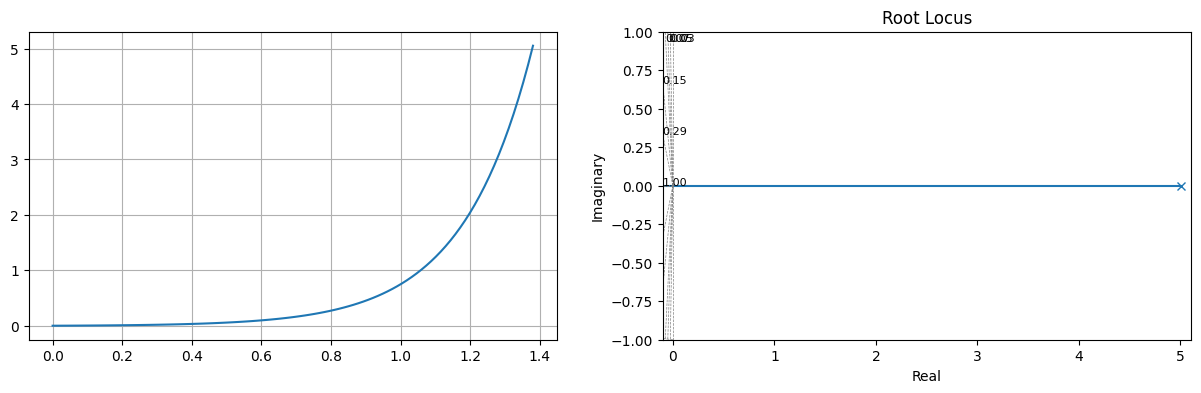

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# INFORMAÇÕES DA RESPOSTA

In [5]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 5.050495563903801,
 'peakTime': 1.3803363597998035,
 'settlingTime': None,
 'finalValue': 5.050495563903801,
 'error': 4.050495563903801}

# REQUISITOS DO SISTEMA

(0.5911550337988976, 1.3532829025560638, -0.8 + 1.092*I)

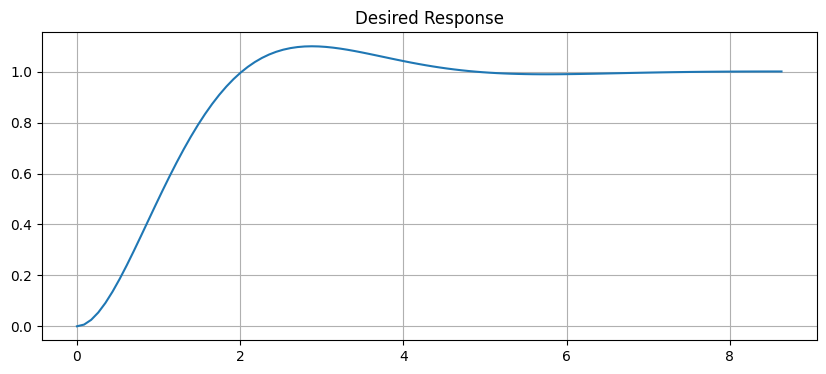

In [6]:
Ts = 5.0
UP = 0.1

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K_p \, \big(1 + \frac{1}{T_is}\big)\big(\frac{T_ds + 1}{0.1T_ds + 1}\big)$

In [7]:
s = ctl.TransferFunction.s

In [8]:
def getResponsePID(Kp, Ti, Td):
    C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
    G_feedback = ctl.feedback(G*C, 1)

    time, response = ctl.step_response(G_feedback)
    data = getAllInfo(time, response, show=False)

    if data.get('settlingTime') is None:
        return None
    
    data['Kp'] = Kp
    data['Ti'] = Ti
    data['Td'] = Td
    return data

getResponsePID(1, 1, 1)

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]


In [9]:
Kp_data = np.linspace(0.01, 100, 10)
Ti_data = np.linspace(0.01, 5, 10)
Td_data = np.linspace(0.01, 5, 10)

In [10]:
data = []

for Kp in Kp_data:
    for Ti in Ti_data:
        for Td in Td_data:
            response = getResponsePID(Kp, Ti, Td)

            if response is None:
                continue
            
            data.append(response)

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\linalg\_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\linalg\_matfuncs.py:358: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1056: RuntimeWarning: overflow encountered in matmul
  yout = C @ xout + D @ U
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [16]:
def displayLimits(df):
    display(df.head())
    print('settlingTime: ', (df.settlingTime.min().round(3), df.settlingTime.max().round(3)))
    print('overshoot:    ', (df.overshoot.min().round(3), df.overshoot.max().round(3)))
    print('error:        ', (df.error.min().round(3), df.error.max().round(3)))


df = pd.DataFrame(data)
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.745090,1.746686,0.237891,1.129982,1.000914,0.000914,11.12,0.01,0.564444
1,0.846488,1.846875,0.197470,2.056981,1.000210,0.000210,11.12,0.01,1.118889
2,0.938686,1.938920,0.190112,3.057635,1.000121,0.000121,11.12,0.01,1.673333
3,0.998199,1.998370,0.187208,4.914217,1.000086,0.000086,11.12,0.01,2.227778
4,1.038645,2.038933,0.185584,7.964630,1.000142,0.000142,11.12,0.01,2.782222


settlingTime:  (0.336, 10320.239)
overshoot:     (0.0, 4.237)
error:         (0.0, 4002.741)


### ANÁLISE DOS DADOS

In [17]:
df = df.loc[(df.settlingTime > 1) & (df.settlingTime < 20)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.745090,1.746686,0.237891,1.129982,1.000914,0.000914,11.12,0.01,0.564444
1,0.846488,1.846875,0.197470,2.056981,1.000210,0.000210,11.12,0.01,1.118889
2,0.938686,1.938920,0.190112,3.057635,1.000121,0.000121,11.12,0.01,1.673333
3,0.998199,1.998370,0.187208,4.914217,1.000086,0.000086,11.12,0.01,2.227778
4,1.038645,2.038933,0.185584,7.964630,1.000142,0.000142,11.12,0.01,2.782222


settlingTime:  (1.011, 19.254)
overshoot:     (0.247, 1.845)
error:         (0.0, 0.005)


In [18]:
df = df.loc[(df.overshoot > 0.2) & (df.overshoot < 0.3)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
151,0.286783,1.287274,0.440651,10.685792,1.000382,0.000382,88.89,0.564444,5.000000
193,0.287739,1.288453,0.865545,8.511192,1.000555,0.000555,100.00,0.564444,3.891111
194,0.261409,1.261919,0.675074,9.571340,1.000404,0.000404,100.00,0.564444,4.445556
195,0.247426,1.247829,0.407122,10.510526,1.000323,0.000323,100.00,0.564444,5.000000


settlingTime:  (8.511, 10.686)
overshoot:     (0.247, 0.288)
error:         (0.0, 0.001)


In [19]:
df = df.loc[df.error == df.error.min()]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
195,0.247426,1.247829,0.407122,10.510526,1.000323,0.000323,100.0,0.564444,5.0


settlingTime:  (10.511, 10.511)
overshoot:     (0.247, 0.247)
error:         (0.0, 0.0)


In [20]:
row = df.iloc[0].to_dict()
Kp, Ti, Td = row['Kp'], row['Ti'], row['Td']
Kp, Ti, Td

(100.0, 0.5644444444444445, 5.0)

# RESPOSTA CONTROLADA

In [22]:
s  = ctl.TransferFunction.s

C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
C

TransferFunction(array([282.22222222, 556.44444444, 100.        ]), array([0.28222222, 0.56444444, 0.        ]))

In [23]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([ 7.14022222, 14.07804444,  2.53      ]), array([ 0.28222222, -0.84790844, -2.82470578,  0.        ]))

In [24]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 7.14022222, 14.07804444,  2.53      ]), array([ 0.28222222,  6.29231378, 11.25333867,  2.53      ]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (-20.359+0j) (-1.674+0j) (-0.263+0j)
zeros:  (-1.772+0j) (-0.2+0j)


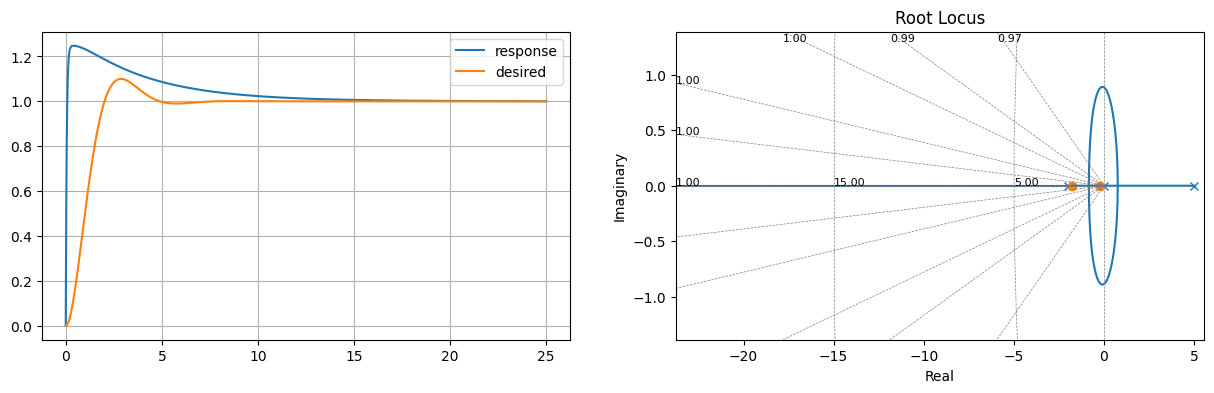

In [25]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 5*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [ ]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.0466774159920459
valor de pico:  1.0470499072775696
tempo de pico:  0.4114114114114114
tempo de assentamento:  0.9369369369369369
valor final:  1.0003558797389076
erro:  0.00035587973890760516


# APLICANDO VÁRIOS STEPS

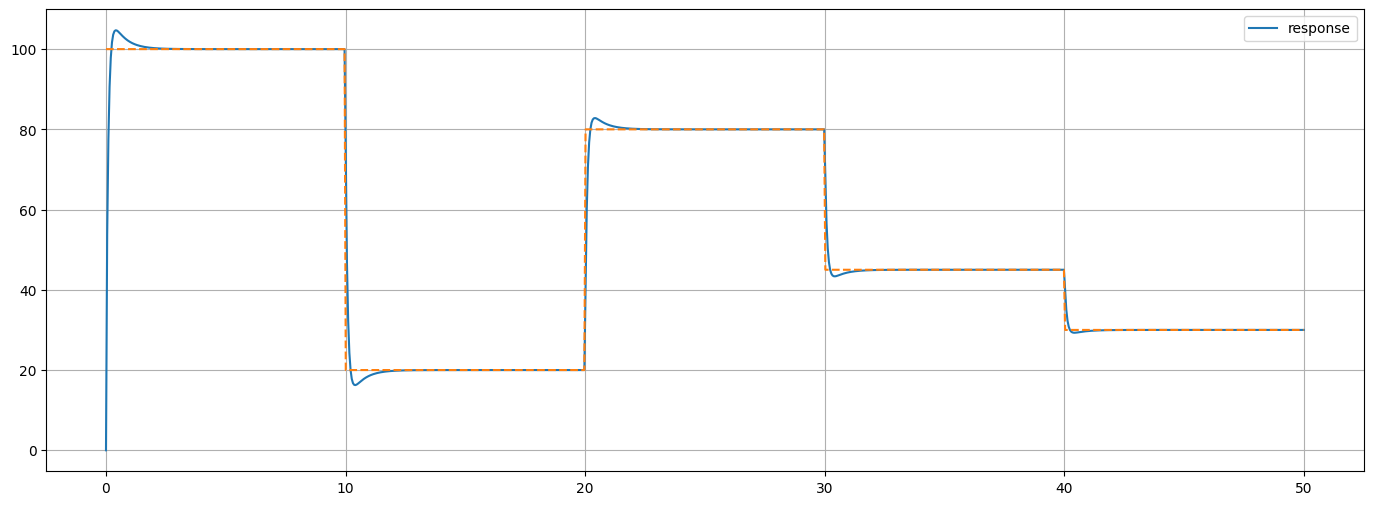

In [ ]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()